# Short-time Fourier Transformation
on audio files

## Load audio files

In [14]:
import os
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('..', '..', 'src_audio')
load_content = False
description = ['key C, mode minor', 'key C, mode major',
               'key C#, mode minor', 'key C#, mode major',
               'key D, mode minor', 'key D, mode major',
               'key D#, mode minor', 'key D#, mode major',
               'key E, mode minor', 'key E, mode major',
               'key F, mode minor', 'key F, mode major',
               'key F#, mode minor', 'key F#, mode major',
               'key G, mode minor', 'key G, mode major',
               'key G#, mode minor', 'key G#, mode major',
               'key A, mode minor', 'key A, mode major',
               'key A#, mode minor', 'key A#, mode major',
               'key B, mode minor', 'key B, mode major']

src_audio_data = datasets.load_files (container_path=container_path,
                                      description=description,
                                      load_content=load_content,
                                      random_state=PARAM_RND_STATE)

In [15]:
src_audio_data.keys ()

dict_keys(['target', 'target_names', 'filenames', 'DESCR'])

## Prepare audio files and perform FFT

<a href='https://docs.scipy.org/doc/scipy/reference/signal.html'>https://docs.scipy.org/doc/scipy/reference/signal.html</a>

<a href='https://stackoverflow.com/questions/604453/analyze-audio-using-fast-fourier-transform'>https://stackoverflow.com/questions/604453/analyze-audio-using-fast-fourier-transform</a>

<a href='https://stackoverflow.com/questions/18248102/removal-of-dc-offset-using-highpass-fft-filter'>https://stackoverflow.com/questions/18248102/removal-of-dc-offset-using-highpass-fft-filter</a>


explanation of signal data:
- *sig_fs* = sampling rate (samples per second)
- *sig_ch* = number of channels
- *sig_N* = number of samples
- *sig_nw* = sample width (bytes)
- *sig_len* = length of signal (seconds)
- *sig* = signal data (array of samples)

In [34]:
# ----- read audio signal
from scipy.io import wavfile

def read_audio_signal (filename):
    print ('>>> reading audio file...', end=' ', flush=True)
    sig_fs, sig = wavfile.read (filename)
    print ('done')
    
    return sig_fs, sig


# ----- signal preparation
from scipy import signal

PARAM_DEC_FAC = 2 # PARAM: decimation factor
def prepare_signal (sig_fs, sig):
    sig_prep = np.copy (sig)
    
    print ('>>> reducing signal to one channel...', end=' ', flush=True)
    sig_ch = len (sig.shape)
    if sig_ch == 2:
        sig_prep = sig_prep.sum (axis=1) / 2
    print ('done')
    
    print ('>>> decimation of signal to (factor {})...'.format (PARAM_DEC_FAC), end=' ', flush=True)
    sig_prep = signal.decimate (sig_prep, q=PARAM_DEC_FAC, ftype='fir').astype (dtype=sig.dtype, copy=False)
    print ('done')
    
    return int (sig_fs/PARAM_DEC_FAC), sig_prep


# ----- slice signal in parts with number of samples are to the power of 2
import math
import numpy as np

PARAM_N = 1<<13 # PARAM: number of samples for one dft
def slice_signal (sig):
    print ('>>> slicing signal...', end=' ', flush=True)
    sig_N = sig.shape[0]
    num_slices = math.floor (sig_N / PARAM_N)
    if (num_slices*PARAM_N < sig_N):  # one more slice usually needed -> checked here
        num_slices += 1
    sig_slices = np.empty ((num_slices, PARAM_N))

    for i in range (num_slices):
        sl = np.copy (sig)[i*PARAM_N:(i+1)*PARAM_N]
        # only last slice of source signal will differ in length
        if (i == (num_slices-1)):
            num_zeros = PARAM_N-sl.size
            sl = np.append (sl, np.full (num_zeros, 0, dtype=sl.dtype))
    
        sig_slices[i] = sl
    print ('done')
    print ('[i] signal sliced in {} parts, each {} samples.'.format (sig_slices.shape[0], sig_slices.shape[1]))
    
    return sig_slices


# ----- windowing signal (Hanning window is used)
import numpy as np
from scipy import signal

PARAM_WIN = signal.hann (PARAM_N) # PARAM: type of window
def window_signal (sig_slices):
    sig_slices_win = np.copy (sig_slices)
    print ('>>> windowing signal...', end=' ', flush=True)
    for i in range (sig_slices_win.shape[0]):
        sig_slices_win[i] = sig_slices_win[i]*PARAM_WIN
    print ('done')
    
    return sig_slices_win


# ----- zero-padding of signal
# number of samples of the time-domain signal dictate the resolution in the frequency-domain
import numpy as np

PARAM_N_ZEROS = 1<<13 # PARAM: number of zeros to add
def zpad_signal (sig_slices):
    print ('>>> zero-padding signal...', end=' ', flush=True)
    sig_slices_zpad = np.empty ((sig_slices.shape[0], sig_slices.shape[1]+PARAM_N_ZEROS))
    for i in range (sig_slices.shape[0]):
        sig_slices_zpad[i] = np.append (sig_slices[i], np.full (PARAM_N_ZEROS, 0, dtype=sig_slices[i].dtype))
    print ('done')
    print ('[i] new shape of signal slice', sig_slices_zpad.shape)
    
    return sig_slices_zpad


# ----- discrete Fourier transform
import numpy as np
import scipy
import scipy.fftpack

def dft_signal (sig_fs, sig_slices):
    print ('>>> performing Fourier transformation...', end=' ', flush=True)
    # retrieve Fourier Transform coefficients
    # calculate magnitude of the FFT coefficients (= absolute value of each complex coefficient)
    sig_fft_mags = np.empty (sig_slices.shape)
    for i in range (sig_slices.shape[0]):
        sig_fft_mags[i] = abs (scipy.fft (sig_slices[i]))

    # get the frequency bin centers in cycles per unit of the sample spacing (with zero at the start)
    freq_bins = list (range (0, len (sig_fft_mags[0])))
    # convert bins to frequency range
    freq_bins_f = (np.array (freq_bins)/len(sig_fft_mags[0])) * sig_fs
    print ('done')
    
    return sig_fft_mags, freq_bins_f

In [56]:
# ----- pitch frequencies of 12 tone equal temperament
import numpy as np

pitch_A0 = 27.5
pitch_Ax = np.array ([pitch_A0*(2**n) for n in range (-1, 11)])
twtet_pitch_ratios = np.array ([2**(n*1/12) for n in range (-9, 3)])

twtet_pitches = np.empty ((11,12)) # shape is 11 octaves, each 12 pitches
for i in range (11):
    twtet_pitches[i] = pitch_Ax[i] * twtet_pitch_ratios

twtet_pitches = twtet_pitches.flatten ()
# MIDI notation has only 128 numbers
#twtet_pitches = twtet_pitches[:128]
# we take only 108 pitches (extended piano)
pitch_C0_midi = 12
twtet_pitches = twtet_pitches[pitch_C0_midi:120]
print ('[i] 12-TET pitches')
print ('  count:', twtet_pitches.size)
print ('  example: A4= {} Hz'.format (twtet_pitches[69-pitch_C0_midi]))

[i] 12-TET pitches
  count: 108
  example: A4= 440.0 Hz


In [58]:
# ----- make and save image
import matplotlib.pyplot as plt
%matplotlib inline

save_path = os.path.join ('..', '..', 'src_spectro')
def create_spectrogram (sig_fft_mags, freq_bins_f):
    print ('>>> drawing image...', end=' ', flush=True)
    fig, axs = plt.subplots (sig_fft_mags.shape[0], 1, sharex=True)
    dpi = fig.get_dpi ()
    w = twtet_pitches.size*2
    h = twtet_pitches.size*2 #sig_prep_fs/10
    fig.set_size_inches (w/dpi,h/dpi)
    for i in range (sig_fft_mags.shape[0]):
        cpy = np.copy (sig_fft_mags[i])
        y = []
        for _ in range (25):
            bin_n = np.argmax (cpy)
            y.append (freq_bins_f[bin_n])
            cpy = np.delete (cpy, bin_n)
        hist, edges = np.histogram (y, bins=twtet_pitches, range=(twtet_pitches.min(), twtet_pitches.max()))
        hist=hist[np.newaxis,:]
        extent=[0, twtet_pitches.size,0,1]
        # [!] LATER use cmap="binary"
        axs[i].imshow (hist, aspect='auto', cmap="gray", extent=extent)
        axs[i].axis ('off')
        axs[i].axes.get_xaxis().set_visible (False)
        axs[i].axes.get_yaxis().set_visible (False)

    plt.subplots_adjust (top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    #plt.savefig (audio_name, dpi=dpi, pad_inches=0, bbox_inches='tight')
    plt.show ()

processing 1 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
/home/ubudan/ml/keyestcnn/lib/python3.5/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


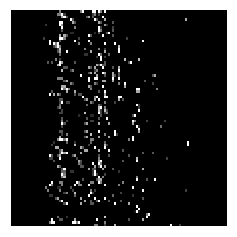

processing 2 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

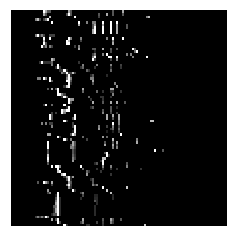

processing 3 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

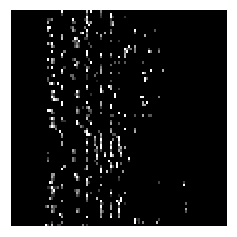

processing 4 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

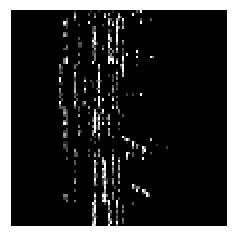

processing 5 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

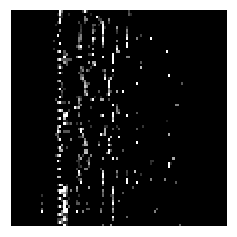

processing 6 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

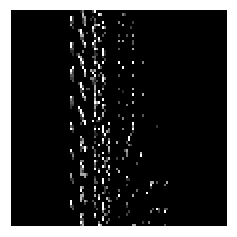

processing 7 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 108 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (108, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

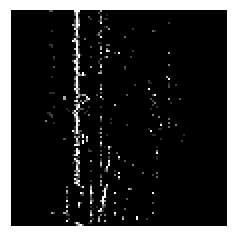

processing 8 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

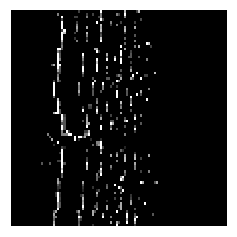

processing 9 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

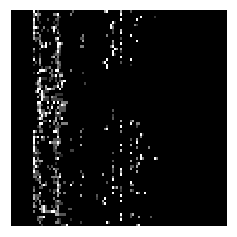

processing 10 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

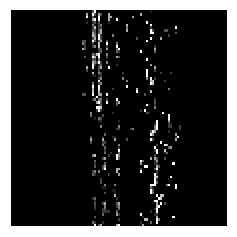

processing 11 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

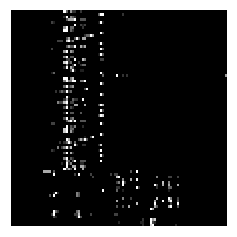

processing 12 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

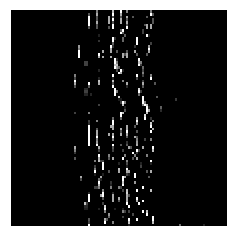

processing 13 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

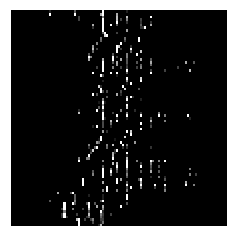

processing 14 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

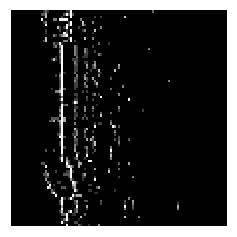

processing 15 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

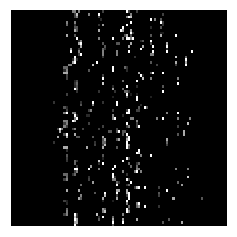

processing 16 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

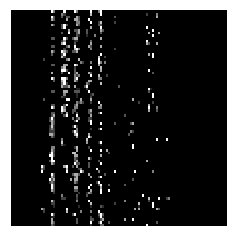

processing 17 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

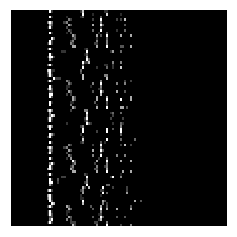

processing 18 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

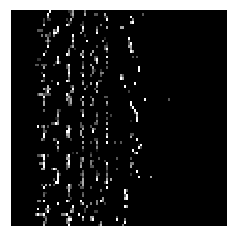

processing 19 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

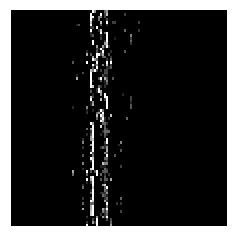

processing 20 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

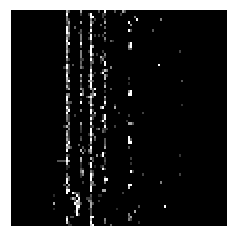

processing 21 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

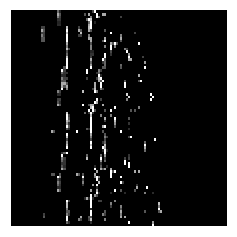

processing 22 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

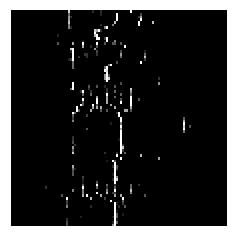

processing 23 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

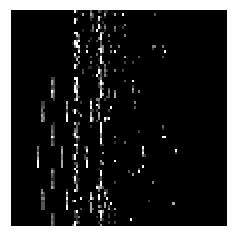

processing 24 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

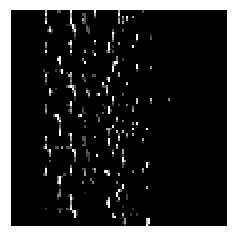

processing 25 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

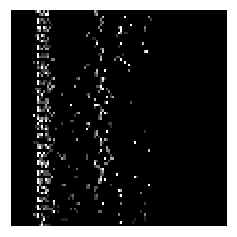

processing 26 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

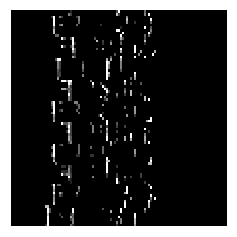

processing 27 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

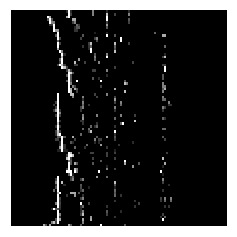

processing 28 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

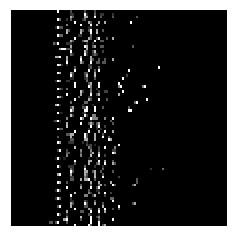

processing 29 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

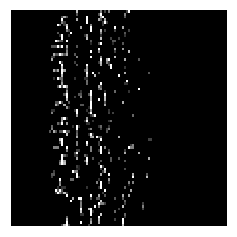

processing 30 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

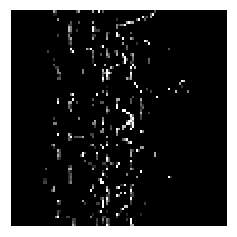

processing 31 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

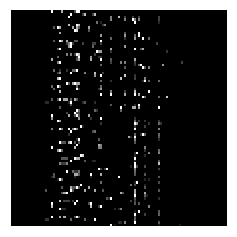

processing 32 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

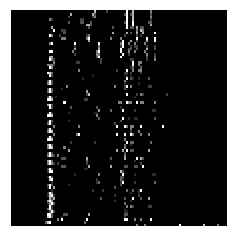

processing 33 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

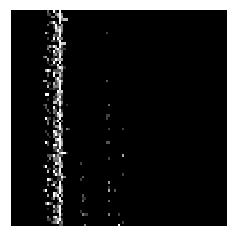

processing 34 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

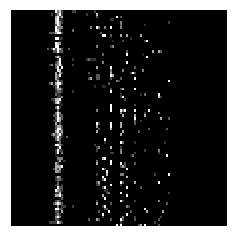

processing 35 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

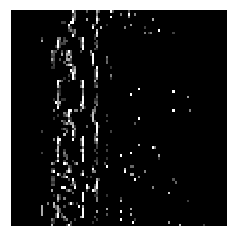

processing 36 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

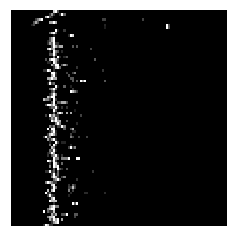

processing 37 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

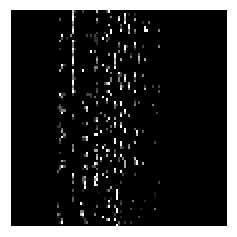

processing 38 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

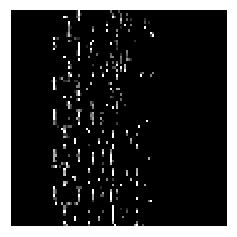

processing 39 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

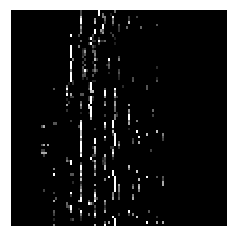

processing 40 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

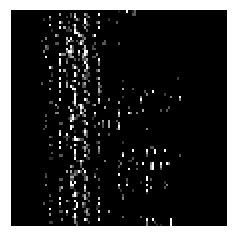

processing 41 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

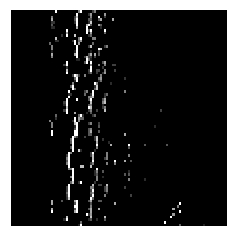

processing 42 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

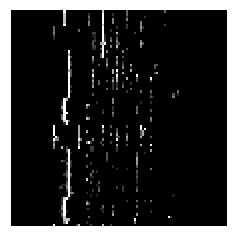

processing 43 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

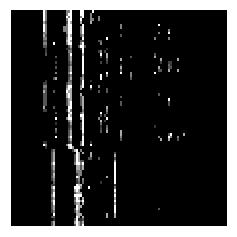

processing 44 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

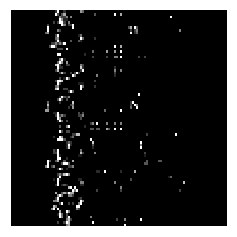

processing 45 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

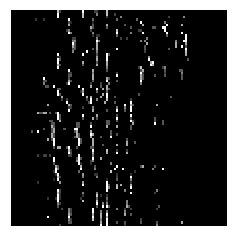

processing 46 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

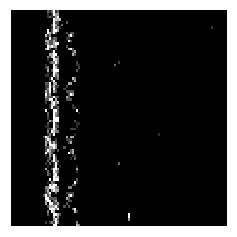

processing 47 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

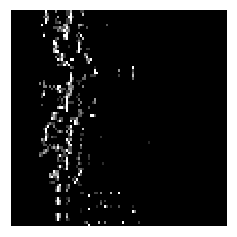

processing 48 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

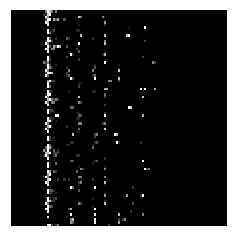

processing 49 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

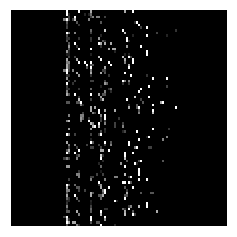

processing 50 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

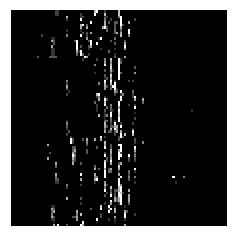

processing 51 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

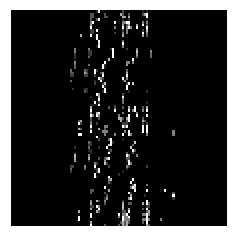

processing 52 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

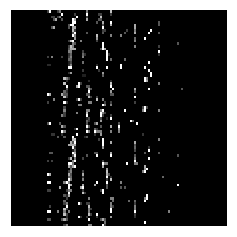

processing 53 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

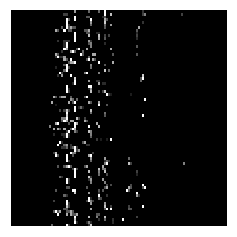

processing 54 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

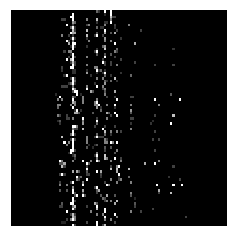

processing 55 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

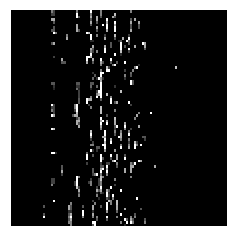

processing 56 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

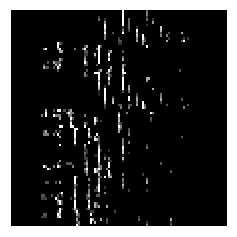

processing 57 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

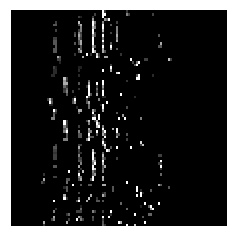

processing 58 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

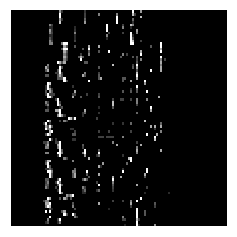

processing 59 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

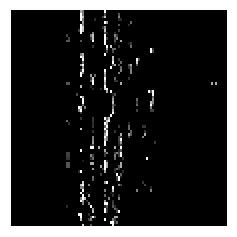

processing 60 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

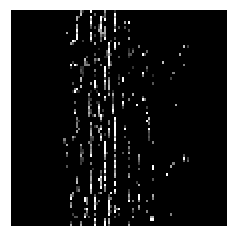

processing 61 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

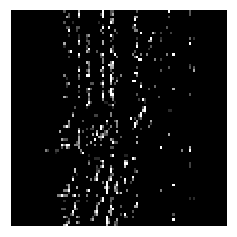

processing 62 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

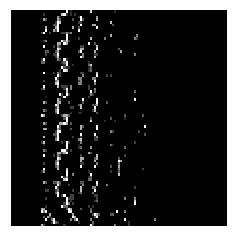

processing 63 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

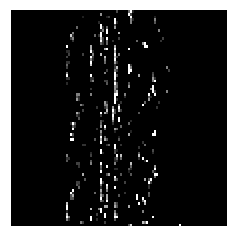

processing 64 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

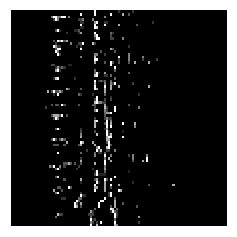

processing 65 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

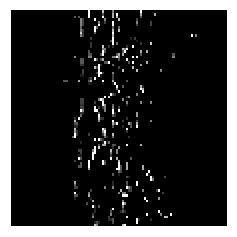

processing 66 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

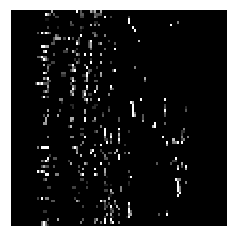

processing 67 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

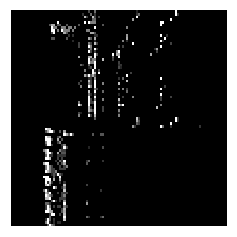

processing 68 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

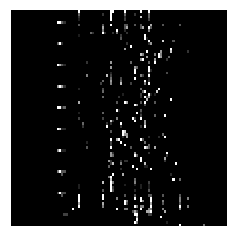

processing 69 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

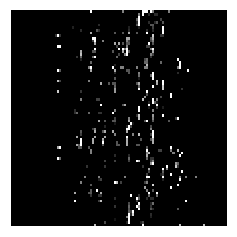

processing 70 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

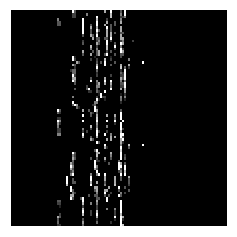

processing 71 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

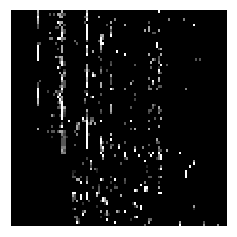

processing 72 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

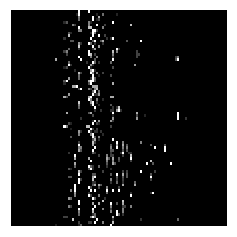

processing 73 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

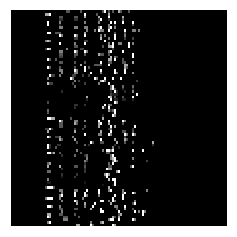

processing 74 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

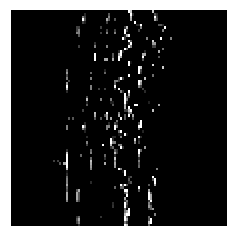

processing 75 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

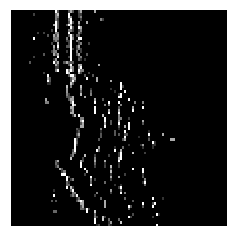

processing 76 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

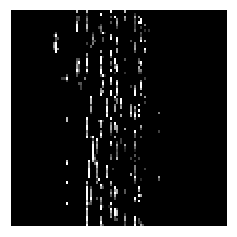

processing 77 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

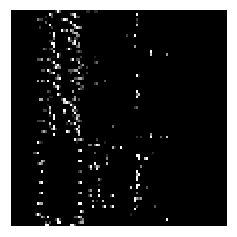

processing 78 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

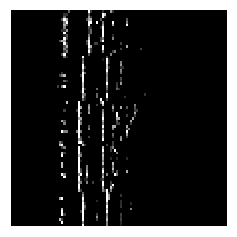

processing 79 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

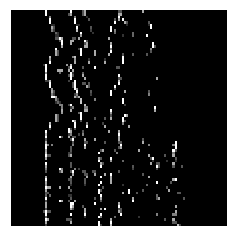

processing 80 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

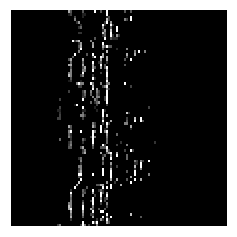

processing 81 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 80 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (80, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

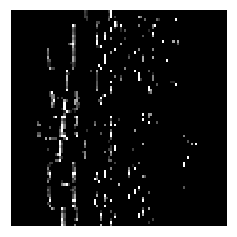

processing 82 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

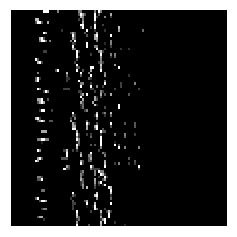

processing 83 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 80 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (80, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

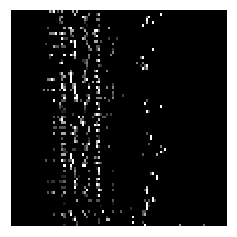

processing 84 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

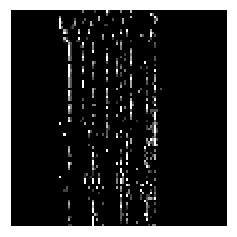

processing 85 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

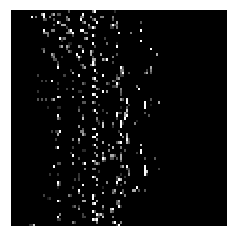

processing 86 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

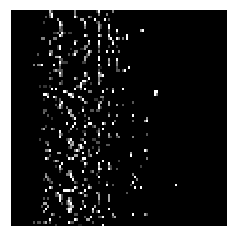

processing 87 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

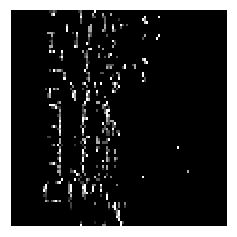

processing 88 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

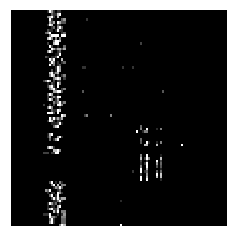

processing 89 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

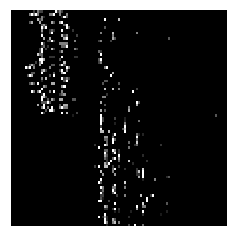

processing 90 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

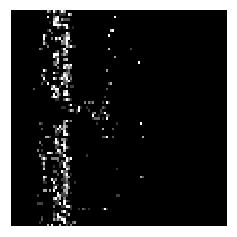

processing 91 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

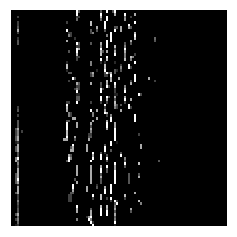

processing 92 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

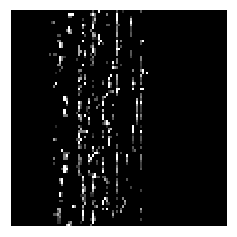

processing 93 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

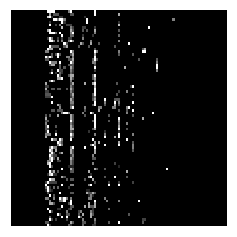

processing 94 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

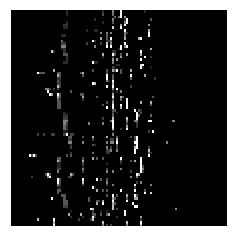

processing 95 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

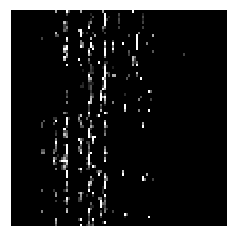

processing 96 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

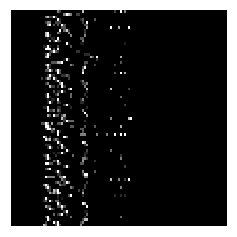

processing 97 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

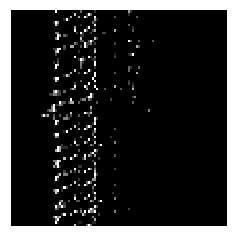

processing 98 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

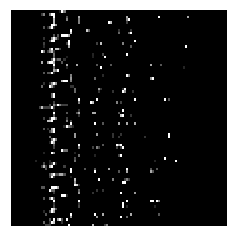

processing 99 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

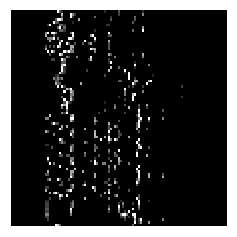

processing 100 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

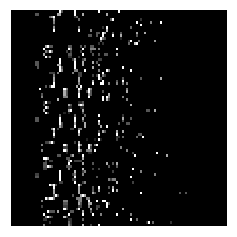

processing 101 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

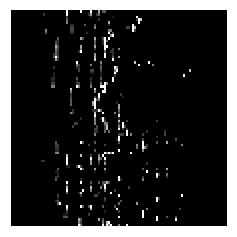

processing 102 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

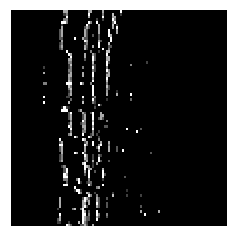

processing 103 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

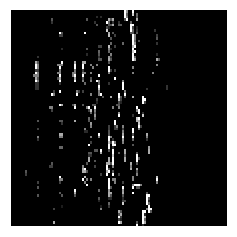

processing 104 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

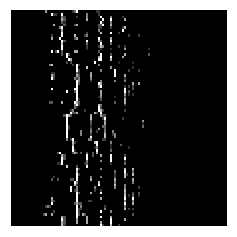

processing 105 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

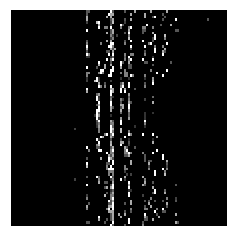

processing 106 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

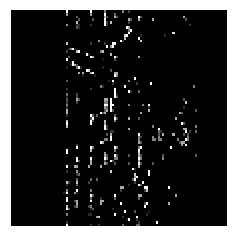

processing 107 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

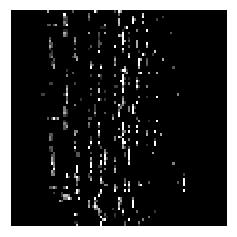

processing 108 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

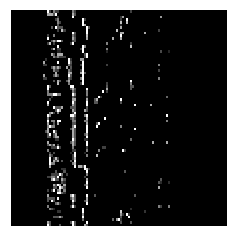

processing 109 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

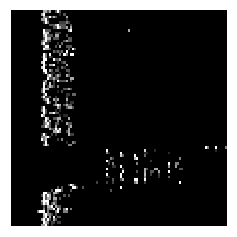

processing 110 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

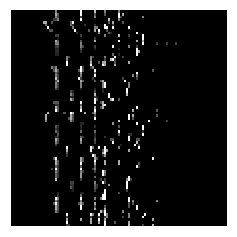

processing 111 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

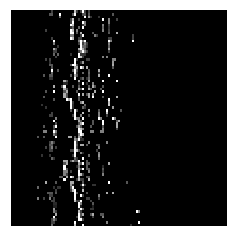

processing 112 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

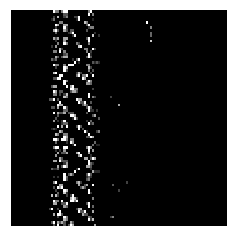

processing 113 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

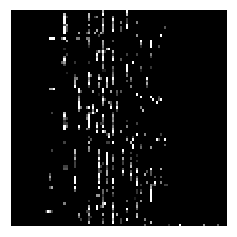

processing 114 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

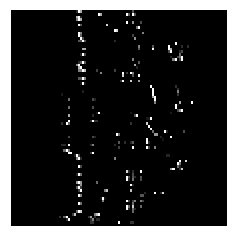

processing 115 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

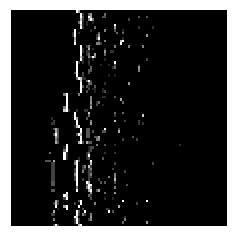

processing 116 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

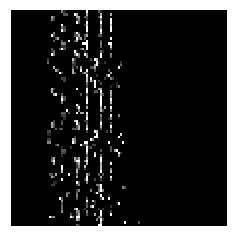

processing 117 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

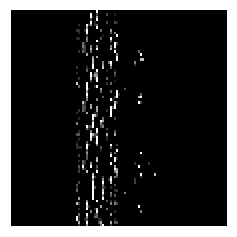

processing 118 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

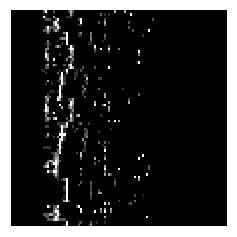

processing 119 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

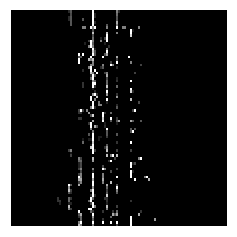

processing 120 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

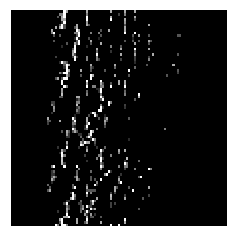

processing 121 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

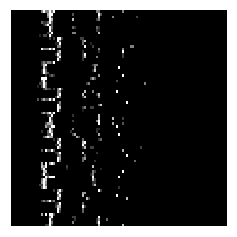

processing 122 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

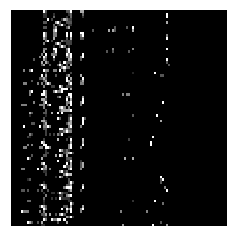

processing 123 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

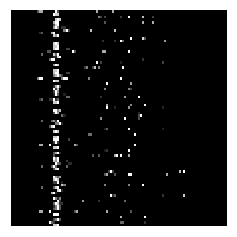

processing 124 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

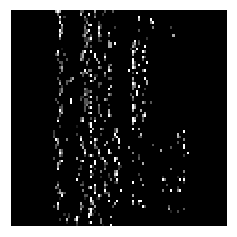

processing 125 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

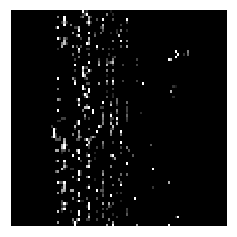

processing 126 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

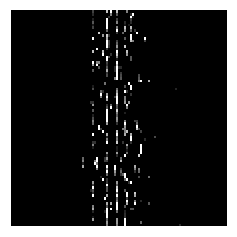

processing 127 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

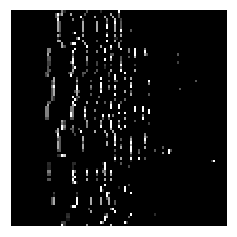

processing 128 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

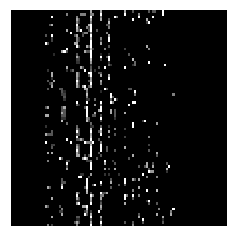

processing 129 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

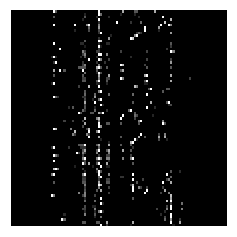

processing 130 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

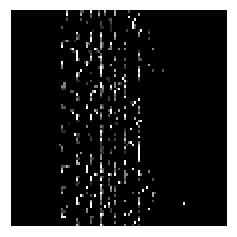

processing 131 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

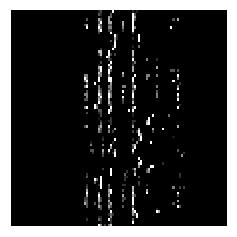

processing 132 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

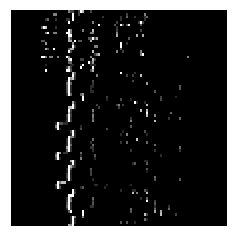

processing 133 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

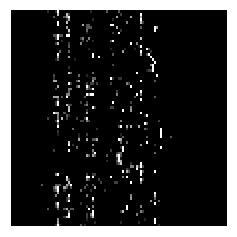

processing 134 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

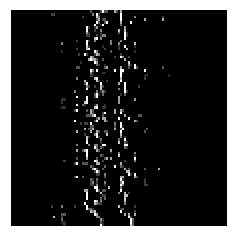

processing 135 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

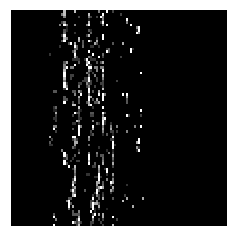

processing 136 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

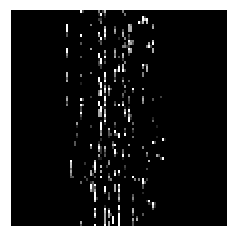

processing 137 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

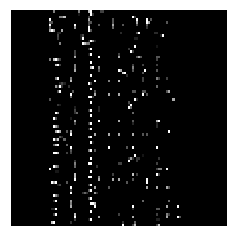

processing 138 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

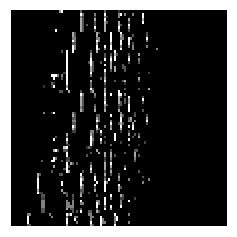

processing 139 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

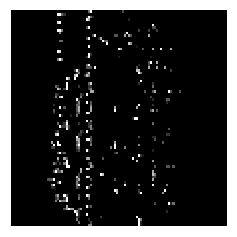

processing 140 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

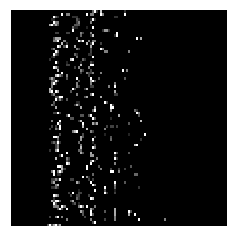

processing 141 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

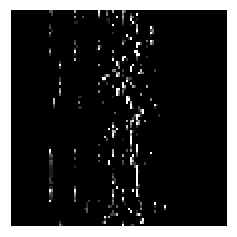

processing 142 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

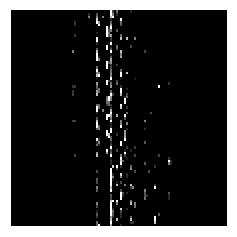

processing 143 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

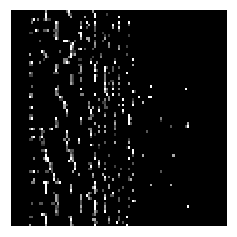

processing 144 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

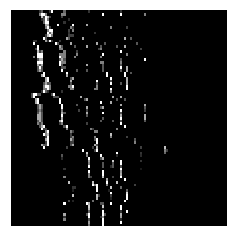

processing 145 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

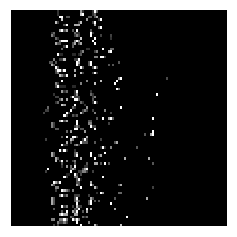

processing 146 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

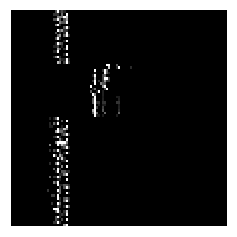

processing 147 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

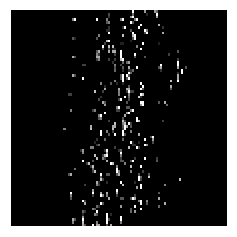

processing 148 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

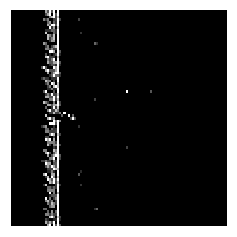

processing 149 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

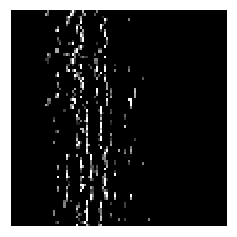

processing 150 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

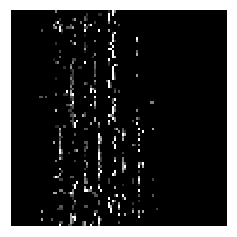

processing 151 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

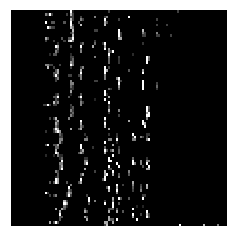

processing 152 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

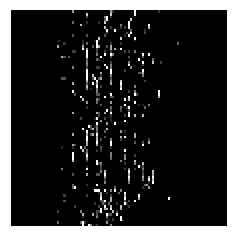

processing 153 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

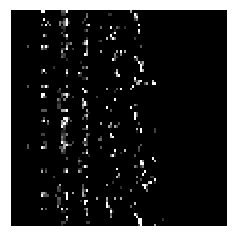

processing 154 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

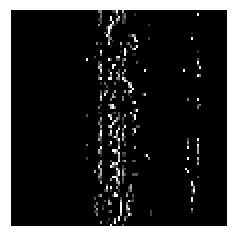

processing 155 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

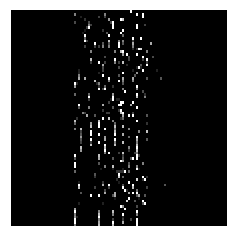

processing 156 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 108 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (108, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

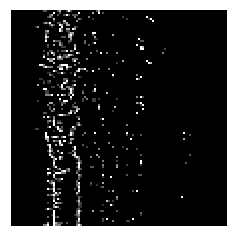

processing 157 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

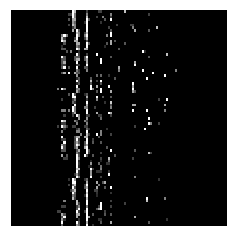

processing 158 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

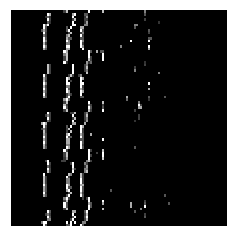

processing 159 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

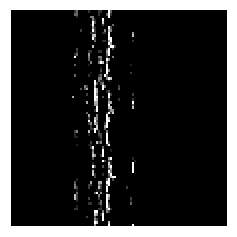

processing 160 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

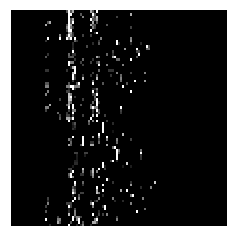

processing 161 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

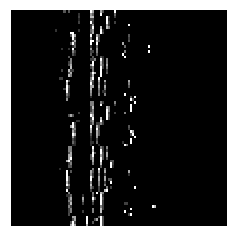

processing 162 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

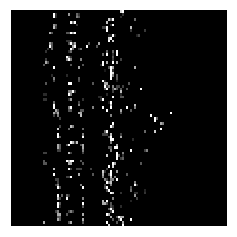

processing 163 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

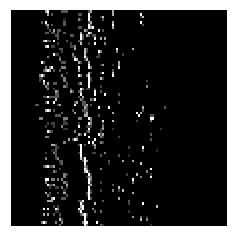

processing 164 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

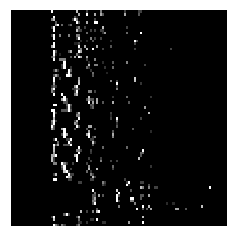

processing 165 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

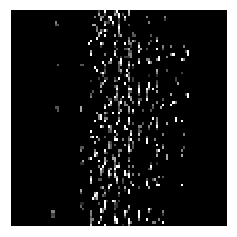

processing 166 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

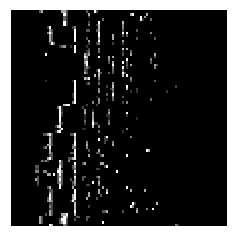

processing 167 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

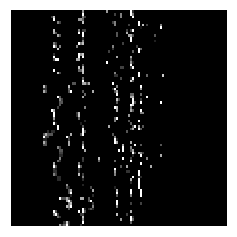

processing 168 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

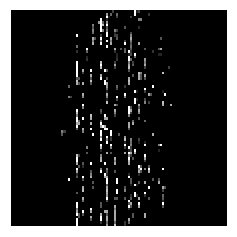

processing 169 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

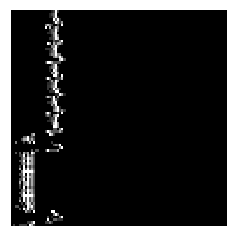

processing 170 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

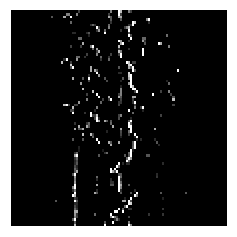

processing 171 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

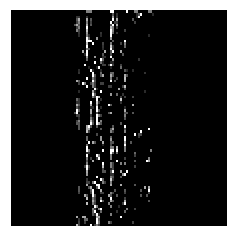

processing 172 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

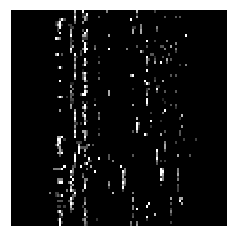

processing 173 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

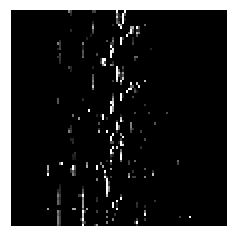

processing 174 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

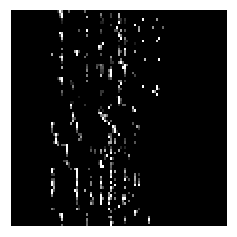

processing 175 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

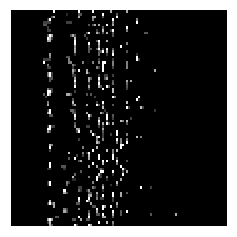

processing 176 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

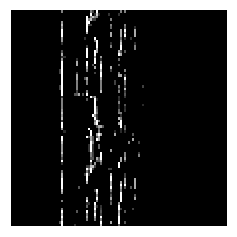

processing 177 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

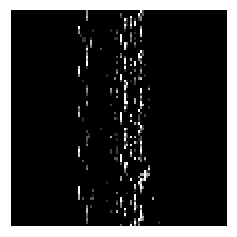

processing 178 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

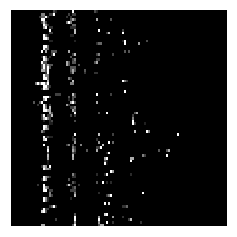

processing 179 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

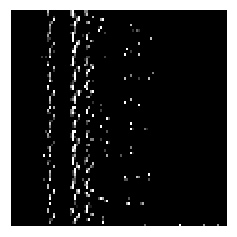

processing 180 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

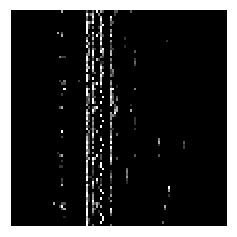

processing 181 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

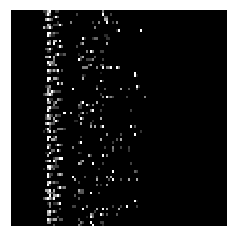

processing 182 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

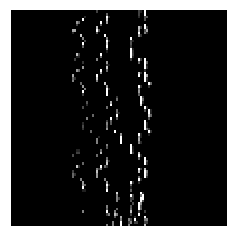

processing 183 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 108 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (108, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

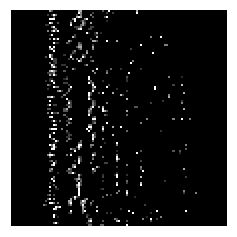

processing 184 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

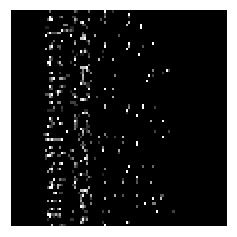

processing 185 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

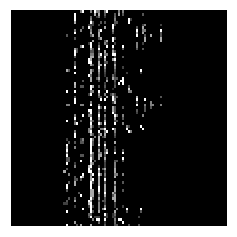

processing 186 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

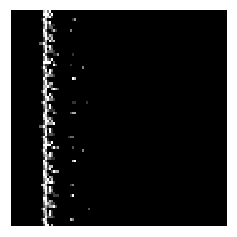

processing 187 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

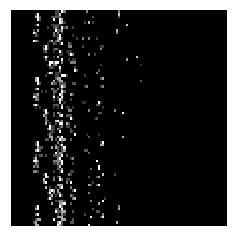

processing 188 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

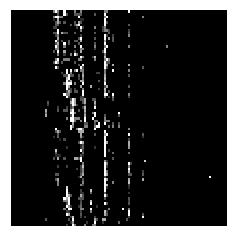

processing 189 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

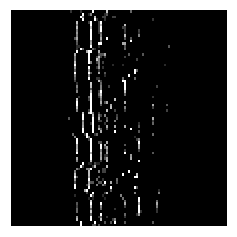

processing 190 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

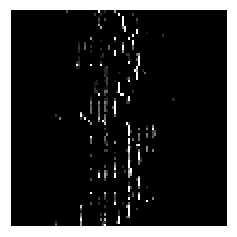

processing 191 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

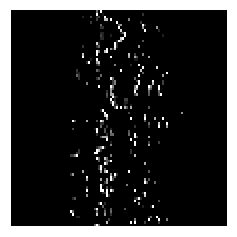

processing 192 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

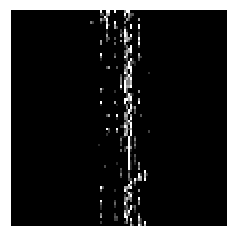

processing 193 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

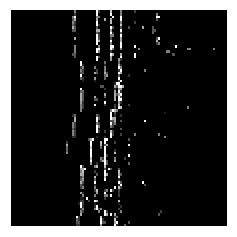

processing 194 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

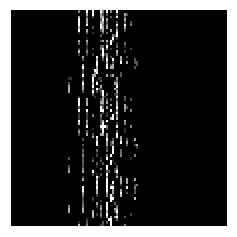

processing 195 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

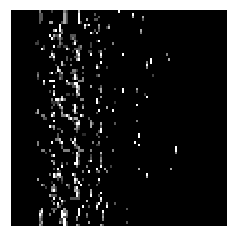

processing 196 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

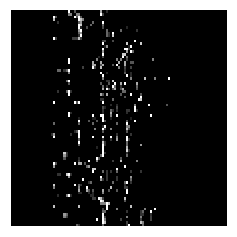

processing 197 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

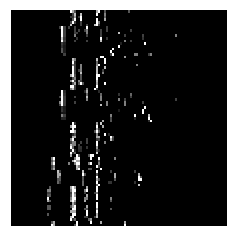

processing 198 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

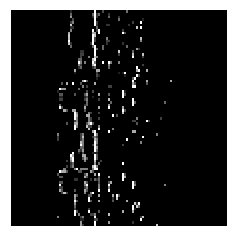

processing 199 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

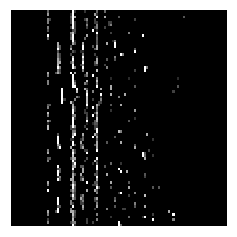

processing 200 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

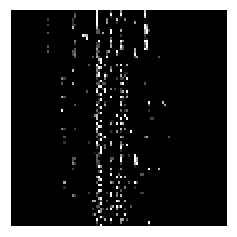

processing 201 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

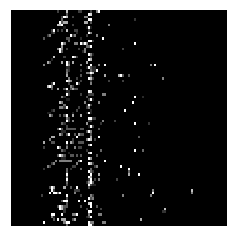

processing 202 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

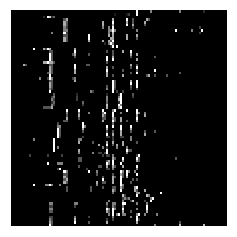

processing 203 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

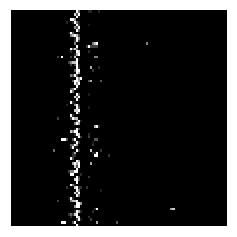

processing 204 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

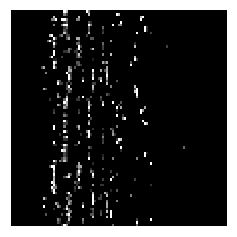

processing 205 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 108 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (108, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

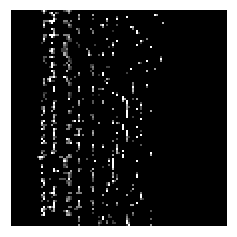

processing 206 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 80 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (80, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

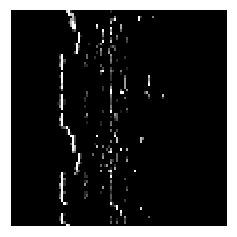

processing 207 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

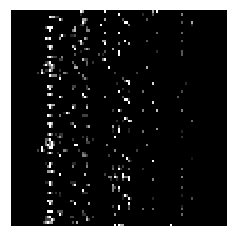

processing 208 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

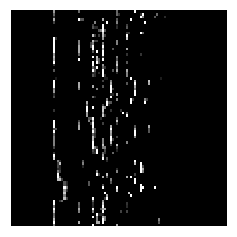

processing 209 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

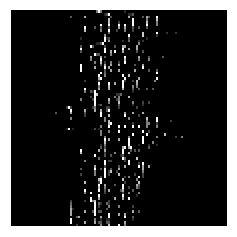

processing 210 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

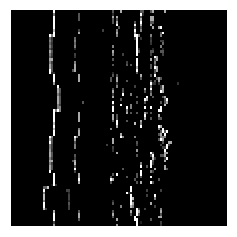

processing 211 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

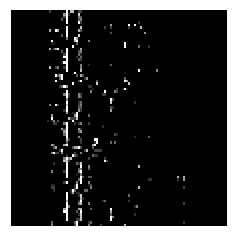

processing 212 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

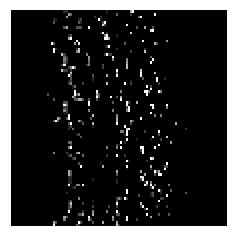

processing 213 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

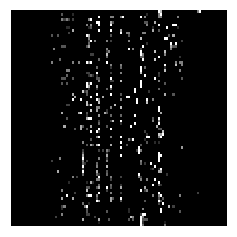

processing 214 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

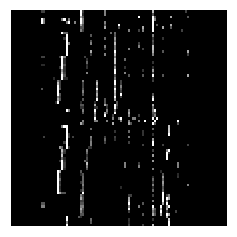

processing 215 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

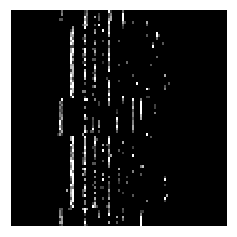

processing 216 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

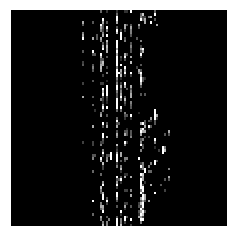

processing 217 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

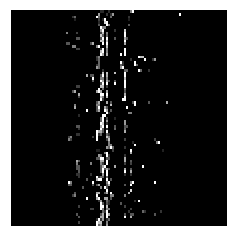

processing 218 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

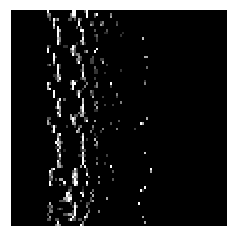

processing 219 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

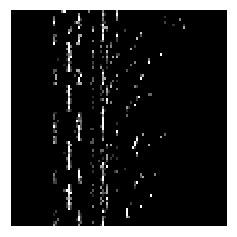

processing 220 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

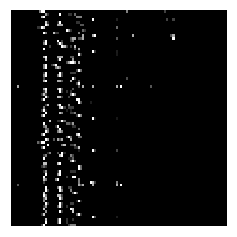

processing 221 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

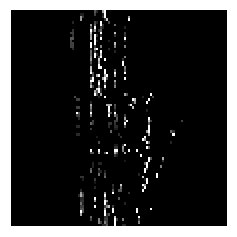

processing 222 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

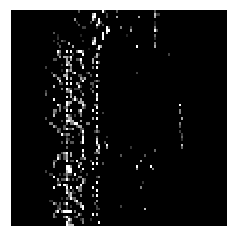

processing 223 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

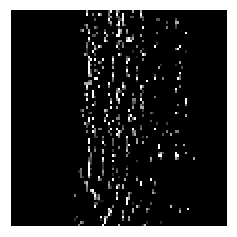

processing 224 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

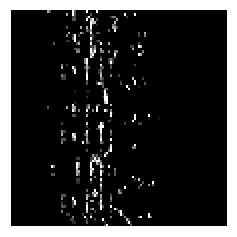

processing 225 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

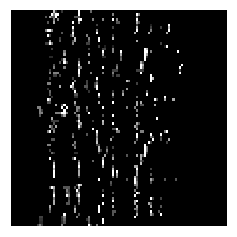

processing 226 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

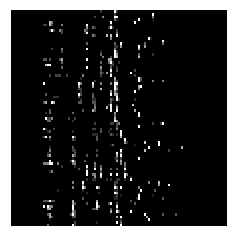

processing 227 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

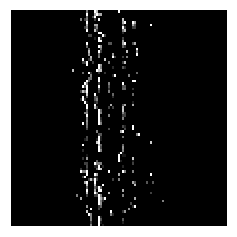

processing 228 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

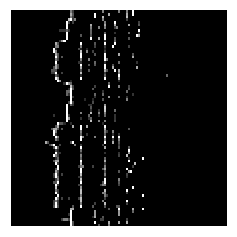

processing 229 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

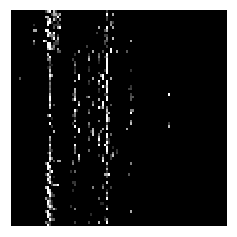

processing 230 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

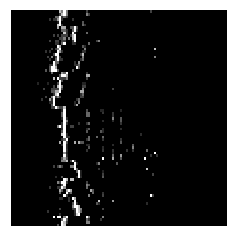

processing 231 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

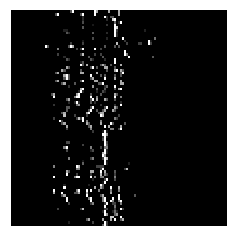

processing 232 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

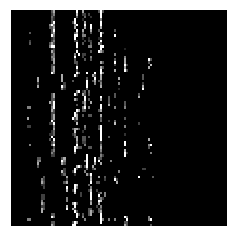

processing 233 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

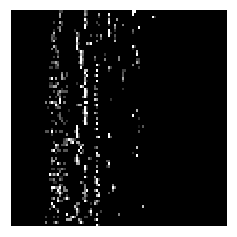

processing 234 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

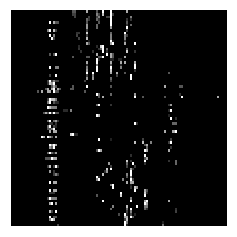

processing 235 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 108 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (108, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

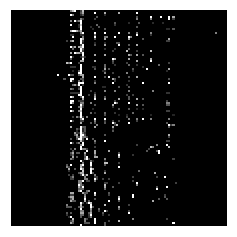

processing 236 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

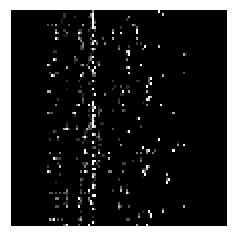

processing 237 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

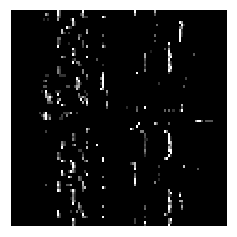

processing 238 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

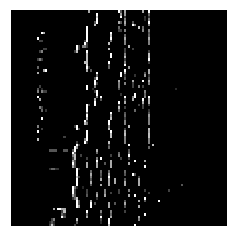

processing 239 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

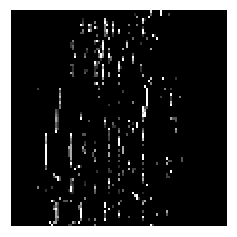

processing 240 of 240 audio files
>>> reading audio file... done
>>> reducing signal to one channel... done
>>> decimation of signal to (factor 2)... done
>>> slicing signal... done
[i] signal sliced in 81 parts, each 8192 samples.
>>> zero-padding signal... done
[i] new shape of signal slice (81, 16384)
>>> performing Fourier transformation... done
>>> drawing image... 

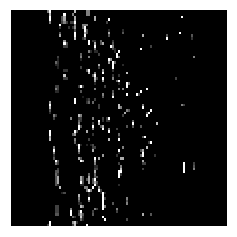

In [61]:
for i, filename in enumerate (src_audio_data['filenames']):
    print ('\rprocessing {} of {} audio files'.format (i+1, src_audio_data['filenames'].shape[0]), end='\n')

    sig_fs, sig = read_audio_signal (filename)

    sig_prep_fs, sig_prep = prepare_signal (sig_fs, sig)

    sig_prep_slices = slice_signal (sig_prep)

    #sig_prep_slices_win = window_signal (sig_prep_slices)

    sig_prep_slices_zpad = zpad_signal (sig_prep_slices)

    sig_fft_mags, freq_bins_f = dft_signal (sig_prep_fs, sig_prep_slices_zpad)
    
    create_spectrogram (sig_fft_mags, freq_bins_f)

[i] Example
signal information:
  channels: 2
  sampling rate: 44100 Hz (S/s)
  number of samples: 1323251 S
  sample width: 2 Bytes = 16 Bits
  length of signal: 30.01 s


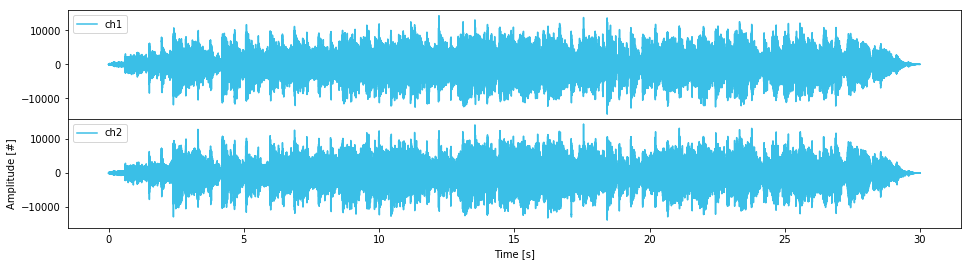

In [53]:
# FYI: EXAMPLE
import matplotlib.pyplot as plt
%matplotlib inline

print ('[i] Example')

sig_ch = len (sig.shape) # number of channels
sig_N = sig.shape[0] # number of samples
sig_nw = sig.dtype.itemsize # sample width
sig_len = sig_N/sig_fs # length of signal

print ('signal information:')
print ('  channels:', sig_ch)
print ('  sampling rate: {} Hz (S/s)'.format (sig_fs))
print ('  number of samples: {} S'.format (sig_N))
print ('  sample width: {} Bytes = {} Bits'.format (sig_nw, sig_nw*8))
print ('  length of signal: {:.2f} s'.format (sig_len))


# plot sample of wav file
t = np.linspace (0, len (sig)/sig_fs, sig_N)

fig, axs = plt.subplots (2, 1, sharex=True, sharey=True)

axs[0].step (t, sig[:,0], c="#3ABFE7", label='ch1')
axs[0].legend (loc='upper left')

axs[1].step (t, sig[:,1], c="#3ABFE7", label='ch2')
axs[1].legend (loc='upper left')

_ = plt.ylim()
fig.set_size_inches ((16., 4.), forward=True)
fig.suptitle ('')
fig.subplots_adjust (hspace=0)

plt.xlabel('Time [s]')
plt.ylabel('Amplitude [#]')

plt.show()

[i] Example
signal information:
  channels: 1
  sampling rate: 22050 Hz (S/s)
  number of samples: 661626 S
  sample width: 2 Bytes = 16 Bits
  length of signal: 30.01 s


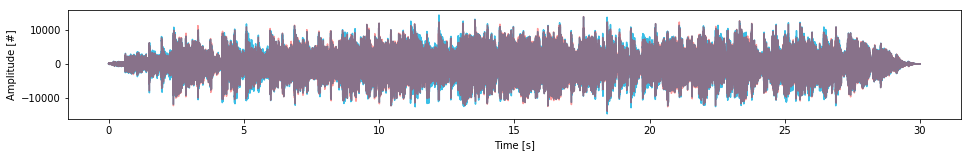

In [54]:
# FYI: EXAMPLE
print ('[i] Example')

sig_prep_ch = len (sig_prep.shape) # number of channels
sig_prep_N = sig_prep.shape[0] # number of samples
sig_prep_nw = sig_prep.dtype.itemsize # sample width
sig_prep_len = sig_prep_N/sig_prep_fs # length of signal

print ('signal information:')
print ('  channels:', sig_prep_ch)
print ('  sampling rate: {} Hz (S/s)'.format (sig_prep_fs))
print ('  number of samples: {} S'.format (sig_prep_N))
print ('  sample width: {} Bytes = {} Bits'.format (sig_prep_nw, sig_prep_nw*8))
print ('  length of signal: {:.2f} s'.format (sig_prep_len))

plt.figure(figsize=(16.,2.))
plt.step (t, sig[:, 0], c="#3ABFE7", label='src ch1')

t_prep = np.linspace (0, len (sig_prep)/sig_prep_fs, sig_prep_N)
plt.step (t_prep, sig_prep, c="#FF0000", alpha=0.4, label='mono')

plt.xlabel('Time [s]')
plt.ylabel('Amplitude [#]')

plt.show ()

In [20]:
# IMAGE EDIT: convert to 8 Bit and rotate by 90 degrees
from PIL import Image

img = Image.open (audio_name+'.png').convert ('L')
img = img.rotate (90)
img.save (audio_name+'_bw'+'.png')
#img.show ()

<a href='http://pages.mtu.edu/~suits/notefreqs.html'>http://pages.mtu.edu/~suits/notefreqs.html</a>

## Short-Time Fourier Transformation (STFT)

## simple example for windowing

### cosine wave and its dft

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fs = 1000 # frames per second
T = 1/fs
N = 1000 # samples
n = list (range (0,N))
t = np.linspace (0, len (n)*T, N)
x = [math.cos (2*math.pi*6.5*_t) for _t in t] # cos with freq of 6.5 Hz

# -----

import scipy
import scipy.fftpack

x_zpad = np.append (x, np.full (99000, 0))
X_ZPAD_mags = abs (scipy.fft (x_zpad))
bins = list (range (0, len (x_zpad)))


# -----

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure (figsize=(16.,6.))
plt.subplot (211)
plt.plot (t, x)
plt.title ('time-domain signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [#]')
plt.grid (True)
plt.subplot (212)
plt.plot (bins[0:1500], X_ZPAD_mags[0:1500])
plt.title ('magnitude spectrum of zero-padded signal')
plt.xlabel ('Frequency bin [#]')
plt.ylabel ('Magnitude [#]')
plt.grid (True)

plt.subplots_adjust (hspace=0.5)
plt.show ()

above DFT magnitude spectrum plot shows the first 1500 bins

the frequency with highest magnitude is calculated by:

bin_num / len (x_zpad) \* fs = 650 / 100.000 \* 1.000 = 6.5 Hz

In [ ]:
# now bins will be converted to frequency range
import matplotlib.pyplot as plt
%matplotlib inline

fax = np.array (bins) * fs / len (x_zpad)

plt.figure (figsize=(16.,3.))
plt.plot (fax[0:1500], X_ZPAD_mags[0:1500])
plt.title ('magnitude spectrum of zero-padded signal')
plt.xlabel ('Frequency [Hz]')
plt.ylabel ('Magnitude [#]')
plt.grid (True)

plt.show ()

print ('frequency with highest magnitude = {} Hz'.format (fax[np.argmax(X_ZPAD_mags)]))

### rectangular window

first: look at signals in time-domain

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Ndisp = 5000

plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (x_zpad[0:Ndisp])
plt.title ('zero-padded signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

t = np.linspace (0, 100000*T, 100000)
sinusoid = [math.cos (2*math.pi*6.5*_t) for _t in t] # cos with freq of 6.5 Hz
plt.subplot (312)
plt.plot (sinusoid[0:Ndisp])
plt.title ('sinusoidal signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

win = np.append (np.ones (1000), np.zeros (99000))
plt.subplot (313)
plt.plot (win[0:Ndisp])
plt.title ('rectangular window' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.ylim (-0.5, 1.5)
plt.grid (True)

plt.subplots_adjust (hspace=0.8)
plt.show ()

Interpretation of rectangular window: the sinusoidal signal (graph 2) is multiplied by the rectangular window (graph 3) in order to get the zero-padded signal (graph 1)

second: now let's see how the requency-domain looks like

In [ ]:
fax_dbl_sided = np.copy (fax)

fax_dbl_sided[-49999:] = fax_dbl_sided[-49999:]-1000


plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (x_zpad))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (x_zpad))[-1000:])
plt.title ('double-sided magnitude spectrum of zero-padded signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.figure (figsize=(16.,6.))
plt.subplot (312)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (sinusoid))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (sinusoid))[-1000:])
plt.title ('double-sided magnitude spectrum of sinusoidal signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

win = np.append (np.ones (1000), np.zeros (99000))
plt.subplot (313)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (win))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (win))[-1000:])
plt.title ('double-sided magnitude of rectangular window')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.subplots_adjust (hspace=0.8)
plt.show ()

As shown, the sinusoidal signal is in general just a line in frequency-domain. But due to the applied rectangular window in time-domain, the dft ends up like for the zero-padded signal.

Consequence: **Convolution** = multiplication in time-domain results in convolution in frequency-domain

### hanning window
same as above, nut now with hanning window

In [ ]:
### time-domain signals

from scipy import signal
import scipy.fftpack

import matplotlib.pyplot as plt
%matplotlib inline

Ndisp = 5000

# THIS IS THE IMPORTANT PART - multiply window with time-domain signal
han_win = signal.hann (N)
x_zpad_win = np.append (x*han_win, np.full (99000, 0))

plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (x_zpad_win[0:Ndisp])
plt.title ('zero-padded signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

t = np.linspace (0, 100000*T, 100000)
sinusoid = [math.cos (2*math.pi*6.5*_t) for _t in t] # cos with freq of 6.5 Hz
plt.subplot (312)
plt.plot (sinusoid[0:Ndisp])
plt.title ('sinusoidal signal' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)


plt.subplot (313)
plt.plot (np.append (han_win, np.zeros (99000))[0:Ndisp])
plt.title ('hanning window' + ' (first {} samples)'.format (Ndisp))
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.ylim (-0.5, 1.5)
plt.grid (True)

plt.subplots_adjust (hspace=0.8)
plt.show ()

sinusiodal signal is multiplied with hanning window to get the zero-padded signal (graph 1)

In [ ]:
# frequency-domain signals

from scipy import signal
import scipy.fftpack

import matplotlib.pyplot as plt
%matplotlib inline


X_ZPAD_win_mags = abs (scipy.fft (x_zpad_win))
#bins = list (range (0, len (x_zpad)))


fax_dbl_sided = np.copy (fax)

fax_dbl_sided[-49999:] = fax_dbl_sided[-49999:]-1000


plt.figure (figsize=(16.,6.))
plt.subplot (311)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (x_zpad_win))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (x_zpad_win))[-1000:])
plt.title ('double-sided magnitude spectrum of zero-padded signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.figure (figsize=(16.,6.))
plt.subplot (312)
plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (sinusoid))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (sinusoid))[-1000:])
plt.title ('double-sided magnitude spectrum of sinusoidal signal')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.subplot (313)

plt.plot (fax_dbl_sided[:1000], abs (scipy.fft (np.append (han_win, np.zeros (99000))))[:1000])
plt.plot (fax_dbl_sided[-1000:], abs (scipy.fft (np.append (han_win, np.zeros (99000)))[-1000:]))
plt.title ('double-sided magnitude of hanning window')
plt.xlabel ('Sample [#]')
plt.ylabel ('Amplitude [#]')
plt.grid (True)

plt.tight_layout ()
plt.show ()

## influence of zero-padding
the more zeros padded, the higher the resolution in frequency-domain

since the dft-bins are dictated by the number of samples in time-domain signal

the lower res spectrums are a sampled version of the higher res ones

## deprecated stuff
just for information - messy style

In [ ]:
# read wav file
import wave
import numpy as np

wav_params = None
wav_frames = None
with wave.open (audio_out) as wav_file:
    wav_params = wav_file.getparams ()
    wav_frames = wav_file.readframes (-1)

print ('signal information:')
print ('  channels:', wav_params[0])
print ('  sampling rate: {} Hz (S/s)'.format (wav_params[2]))
print ('  number of samples: {} S'.format (wav_params[3]))
print ('  sample width: {} Bytes = {} Bits'.format (wav_params[1], wav_params[1]*8))
print ('  length of signal: {:.2f} s'.format (wav_params[3]/wav_params[2]))
print ('example of signal samples:')
print ('  ', wav_frames[30000:30010])
wav_frames = np.frombuffer (wav_frames, dtype=np.int16)
print ('  ', wav_frames[30000:30010])
print (wav_frames.dtype)

In [ ]:
# Fourier transformation requires input signal with number of samples to be a power of 2
# if not, zero-pad the signal
# from https://www.geeksforgeeks.org/smallest-power-of-2-greater-than-or-equal-to-n/
if not (sig_prep_N & (sig_prep_N-1) == 0):
    print ('[i] signal length not a power of 2')
    print ('>>> zero-padding the signal...', end=' ', flush=True)
    # get number of zeros to add
    k = sig_prep_N
    while (k&(k-1) > 0):
        k = k&(k-1)
    k = k<<1
    num_zeros = k - sig_prep_N
    # add zeros to end of signal
    sig_prep = np.append (sig_prep, np.full (num_zeros, 0, dtype=sig_prep.dtype))
    sig_prep_N = sig_prep.shape[0]
    sig_prep_len = sig_prep_N/sig_prep_fs
    print ('done')

print (sig_prep_N)
print (sig_prep_len)

---

# Obsolete

## Decode MP3 to WAV
why obsolete: Initial idea was to store mp3 files since they are smaller in size, and then convert them to wav.

In [ ]:
import subprocess
import os


curr_dir = os.path.abspath ('./')
ffmpeg = os.path.join (curr_dir, 'src', 'ffmpeg-20180719-9cb3d8f-win64-static', 'bin', 'ffmpeg.exe')
ffmpeg_opt_main = '-n -i'
ffmpeg_opt_wav = '-ar 44100 -ac 2'
audio_name = "Rick Astley - Never Gonna Give You up"
#"2017-06-16 - CamelPhat, Elderbrook - Cola [Original Mix]"
#"2015-05-29 - Tough Love - So Freakin' Tight [Original Mix]"
audio_in = os.path.join ('src', audio_name + '.mp3')
audio_out = os.path.join ('src', audio_name + '.wav')

cmd = ffmpeg + ' ' + ffmpeg_opt_main + ' ' + \
    "\"" + audio_in + "\"" + ' ' + ffmpeg_opt_wav + ' ' + \
    "\"" + audio_out + "\""

subprocess.call (cmd, shell=True)